In [8]:
#data stuff
import time
import pandas as pd
import numpy as np
import datetime as dt

#regression stuff
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

#graph stuff
import seaborn as sns
from plotly.subplots import make_subplots
from plotly import graph_objects as go
import plotly
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None  # default='warn'

__Define functions for easier plotting__

In [9]:
def plot_variables_func(df,plot_list, one_plot=False, title=None, monthly=False):
    if monthly == False:
        x = pd.date_range(df.index.min(), df.index.max())
        y_df = df.copy()
        y_df = y_df.reindex(x)
        plot_me = plot_list
        data = []
        palette =[
        '#1f77b4',  # muted blue
        '#ff7f0e',  # safety orange
        '#7f7f7f',  # middle gray
        '#2ca02c',  # cooked asparagus green
        '#d62728',  # brick red
        '#9467bd',  # muted purple
        '#8c564b',  # chestnut brown
        '#e377c2', # raspberry yogurt pink
        '#1f77b4',  # muted blue
        '#ff7f0e',  # safety orange
        '#7f7f7f',  # middle gray
        '#2ca02c',  # cooked asparagus green
        '#d62728',  # brick red
        '#9467bd',  # muted purple
        '#8c564b',  # chestnut brown
        '#e377c2', # raspberry yogurt pink
        '#1f77b4',  # muted blue
        '#ff7f0e',  # safety orange
        '#7f7f7f',  # middle gray
        '#2ca02c',  # cooked asparagus green
        '#d62728',  # brick red
        '#9467bd',  # muted purple
        '#8c564b',  # chestnut brown
        '#e377c2', # raspberry yogurt pink
        '#1f77b4',  # muted blue
        '#ff7f0e',  # safety orange
        '#7f7f7f',  # middle gray
        '#2ca02c',  # cooked asparagus green
        '#d62728',  # brick red
        '#9467bd',  # muted purple
        '#8c564b',  # chestnut brown
        '#e377c2', # raspberry yogurt pink
        ]

        for i in range(len(plot_me)):
            # Create a trace
            trace = go.Scatter(
                x = df.index,
                y = df.loc[:,plot_me[i]],
                name = plot_me[i],
                line = dict(color = palette[i])
            )

            if one_plot == False:
                data = [trace]
                layout=go.Layout(title=plot_me[i])

                plotly.offline.iplot(go.Figure(data=data, layout=layout), filename='basic-line')
            else:
                data.append(trace)

        if one_plot == True:
            layout=go.Layout(title=title,
                            legend=dict(orientation='h',xanchor = "center",x = 0.5))
            plotly.offline.iplot(go.Figure(data=data, layout = layout), filename='scatter-mode')
    else:
        aggre = {plot_list[i]:'sum' for i in range(len(plot_list))}
        if isinstance(df.index, pd.DatetimeIndex) == False:
            df_m = df.set_index('dte').groupby(pd.Grouper(freq='M')).agg(aggre)
        else:
            df_m = df.groupby(pd.Grouper(freq='M')).agg(aggre)

        plot_me = plot_list
        data = []
        for i in range(len(plot_me)):
            # Create a trace
            trace = go.Scatter(
                x = df_m.index,
                y = df_m.loc[:,plot_me[i]],
                name = plot_me[i]
            )

            if one_plot == False:
                data = [trace]
                layout=go.Layout(title=plot_me[i])
                plotly.offline.iplot(go.Figure(data=data, layout=layout), filename='basic-line')
            else:
                data.append(trace)

        if one_plot == True:
            plotly.offline.iplot(go.Figure(data=data), filename='scatter-mode')

In [10]:
def plot_variables(df, plot_list, one_plot=False, title=None, monthly=False, scaled=False):
    if scaled == True:
        df_scale = df[plot_list]
        for col in df_scale.columns:
            x = df_scale[[col]].values.astype(float)
            min_max_scaler = MinMaxScaler(feature_range=(0,1))
            x_scaled = min_max_scaler.fit_transform(x)
            df_scale[col] = x_scaled
        plot_variables_func(df_scale, plot_list, one_plot=one_plot, title=title, monthly=monthly)
    else:
        plot_variables_func(df, plot_list, one_plot=one_plot, title=title, monthly=monthly)

__function for corr matrix__

In [14]:
def get_corr_matrix(df, var_list, start, end, fontsize=12):

#     label_list = [x.partition('_adstock')[0] for x in var_list]
#     label_list = [x.partition('_impressions')[0] for x in label_list]
#     label_list = [x.replace("fixed"," ") for x in label_list]
#     label_list = [x.replace("_"," ").title() for x in label_list]
    label_list = var_list


    corr = df.loc[start:end][var_list].corr()

    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(15, 12))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(corr, 
#                 xticklabels=label_list, 
#                 yticklabels=label_list, 
                mask=mask, 
                cmap=cmap, 
                vmin=-1,
                vmax=1, 
                center=0,
                square=True, 
                linewidths=.5, 
                annot=True, 
                annot_kws={"size":fontsize}, 
                fmt='.1g'
               )
    plt.tight_layout()

# 0.1 Read in PMD Data

Note: When running back to 2016 or so this costs 90GB, running back through beginning of 2020 costs about 25GB

In [15]:
q = '''
SELECT 
     account
    , attr_window
    , campaign
    , _match
    , campaign_objective
    , date
    , marketing_initiative
    , marketing_segment
    , marketing_subinitiative
    , channel
    , platform
    , sum(case when sor_prod = 'All (Core All, NPV)' then spend else 0 end) spend
    , sum(case when sor_prod = 'All (Core All, NPV)' then clicks else 0 end) clicks
    , sum(case when sor_prod = 'All (Core All, NPV)' then impressions else 0 end) impressions
    , sum(case
            when sor_prod = 'Core' then conversions else null end) digi_conversions
    , sum(case
            when sor_prod = 'Crosswords' then conversions else null end) games_conversions
    , sum(case
            when sor_prod = 'EDU' then conversions else null end) edu_conversions
    , sum(case
            when sor_prod = 'Home Delivery' then conversions else null end) hd_conversions
    , sum(case
            when sor_prod = 'CK' then conversions else null end) ck_conversions     
    , sum(case
            when sor_prod = 'Core All (Core, HD, EDU)' then conversions else null end) core_conversions
    , sum(case
            when sor_prod = 'All (Core All, NPV)' then conversions else null end) all_conversions
FROM `nyt-mkt-prd.paid_media_data.placement_daily_vw`
WHERE date >= '2016-01-01' and attr_window in('Combined')
group by 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11
order by date, campaign, _match

'''

start_time = time.time() 

df = pd.read_gbq(q,
                 project_id ='nyt-bigquery-beta-workspace',
                 dialect='standard',
                 verbose=False)

print(f'time took: {str(round(time.time() - start_time, 2))}')

time took: 272.1


Notes on use of attribution window:
* Use the same attr_window for each channel
* Media team right now uses _combined_ attr_window, which is mostly Media Reported but some quirks
* For this analysis, we should use:
    * __Combined__ and __Media Reported - Click Thru__
* Do one version that looks only at Media Reported click thru and one version that looks at combined


In [18]:
'''
the below is no longer needed - I had terrible wifi in Puerto Rico so had to chunk the data pull
'''
# increment=200000
# chunks=list(range(0, 1838251, increment))

# chunks[-1]+=increment 
# intervals=[[chunks[i-1], chunks[i]+1] for i, e in enumerate(chunks) if i > 0]

# query_str='''
# select * from `nyt-bigquery-beta-workspace.lucas_data.pmd_data_jan_20_to_apr_21`
# order by 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21 limit {end} offset {start}
# '''

# df = pd.DataFrame() 

# for start, end in intervals:  
#     q = query_str.format(start=start, end=end)
#     print(f"running query: {q}")
#     start_time = time.time()  
#     temp_df = pd.read_gbq(q,
#                  project_id ='nyt-bigquery-beta-workspace',
#                  dialect='standard',
#                  verbose=False)
#     print(f'time took: {str(round(time.time() - start_time, 2))}')
#     df = pd.concat([df, temp_df])

'\nthe below is no longer needed - I had terrible wifi in Puerto Rico so had to chunk the data pull\n'

In [19]:
#keep a copy of the original just to be safe
df_safe = df.copy()

In [53]:
df = df_safe.copy()

In [54]:
#idk why there's duplicates but there are... so drop them
print(f"Rows before duplicates removed: {df.shape[0]}")
df.drop_duplicates(inplace=True)
print(f"Rows after duplicates removed: {df.shape[0]}")

Rows before duplicates removed: 1783600
Rows after duplicates removed: 1783600


In [55]:
# df.to_csv('all_pmd_data_jan_20_to_apr_21.csv')

# 0.2 Basic Data Cleaning

### CHECKPOINT: read in data from CSV here if needed. Begin to limit data to just Core media activity

#### Clean the Data

In [56]:
#some Twigeo campaigns don't get recognized as Games campaigns in PMD, manually correct those
df.loc[(df['marketing_subinitiative'] == 'X-UNKNOWN-X') & 
       (
          (df['campaign'].str.contains('game')) | 
          (df['campaign'].str.contains('xwd')) | 
          (df['campaign'].str.contains('cross'))
       ), 'marketing_subinitiative'] = 'Games (former: Crosswords)'

#### add columns for easier grouping (quarter, month, week) + analysis

In [57]:
#create date-based aggregation columns for easier grouping
df['year_month_cal'] = df['date'].dt.strftime('%Y-%m').astype('datetime64[ns]')
df['year_week_monday'] = df['date'].dt.to_period('W').apply(lambda r: r.start_time)
df['year_quarter'] = df['date'].dt.to_period('Q').apply(lambda r: r.start_time)

/Users/lucas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1088: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [58]:
#create a combined spg_conversions column from games and ck
df['spg_conversions'] = df['games_conversions'] + df['ck_conversions']

In [59]:
#create a composite channel-marketing-initiative column for a pd.melt
df['channel_mkt_init'] = df['channel'] + " - " + df['marketing_initiative']

### Create a DF of Core-Only campaigns

In [60]:
#limit to Core campaigns 
df_core = df[df['marketing_subinitiative'].isin(['Core','CORE Business'])]

#remove mobile partners - conversion data is unreliable in PMD
df_core = df_core[~(df_core['account'].str.contains('Twigeo')) & 
                 ~(df_core['account'] == 'The New York Times App')]

#remove app install and app-based campaigns so we focus only on web
df_core['campaign'] = df_core['campaign'].str.lower()
df_core = df_core[~df_core['campaign'].str.contains('app')]

#limit attribution window to media-reported. We may want to reexamine this analysis in the future using other windows
#such as 7d-all or 1d-all
df_core = df_core[df_core['attr_window'] == 'Combined']

In [61]:
df_core.shape

(1043423, 26)

### Create a DF of SPG-Only Campaigns

In [65]:
spg_df = df[(df['marketing_subinitiative'].isin(['Cooking','Games'])) & 
  ~(df['campaign'].str.contains('app'))]

In [66]:
spg_df.shape

(328532, 26)

In [68]:
spg_df[['ck_conversions','games_conversions']].sum()

ck_conversions       103959.530154
games_conversions     45444.160003
dtype: float64

# 1.1 Top level analysis on Core-to-SPG cross sell (Core campaigns driving CK or Games starts)

In [33]:
#understand overall impact 1 Jan 2019 - 7 Apr 2021
df_core[['core_conversions','games_conversions','ck_conversions']].sum()

core_conversions     1.453656e+06
games_conversions    2.264061e+04
ck_conversions       4.302214e+04
dtype: float64

__Since January 2020, web-based Core media (note: this analysis excludes app-based media) has generated 1.45M starts. It has also recorded 22.6k Games starts and 43.0k Cooking starts which have never been recognized!__

The most recent 5 year LTVs I found for Cooking and Games are as follows: 
* Cooking: $124

* Games: $97

In [36]:
start_sums = df_core[['core_conversions','games_conversions','ck_conversions']].sum().to_frame()
games_val = start_sums.loc['games_conversions'][0] * 97
ck_val = start_sums.loc['ck_conversions'][0] * 124

In [86]:
print('Games added value: ${:>15,.2f}'.format(games_val))
print('CK added value: ${:>18,.2f}'.format(ck_val))
print('Combined value: ${:>18,.2f}'.format(games_val + ck_val, 2))

Games added value: $   2,196,138.71
CK added value: $      5,334,745.18
Combined value: $      7,530,883.89


This means upon initial glance, web-based campaigns since Jan 2019 have generated over $7.5M in unrecognized value based on media reporting. 

However, this is an incomplete picture because we don't know: 
<ol>
    <li> to what extent the core campaigns actually drove these conversions (are they incremental?) </li>
    <li> if these starts were already counted as part of separate CK or Games campaigns (are they deduplicated?) </li>
</ol>

## Create Quarterly, Monthly, Weekly, Daily views of impressions, core starts, SPG starts to understand if there is a consistent relationship

### Quarterly

In [116]:
#group by quarter field
df_core_qtr = df_core.groupby('year_quarter')['spend','clicks','impressions','core_conversions','spg_conversions',
                                         'ck_conversions','games_conversions'].sum()
#rename cols
df_core_qtr.rename(columns = {'spend':'core_spend', 
                           'impressions':'core_impressions', 
                             'spg_conversions':'core_spg_conversions', 
                             'ck_conversions':'core_ck_conversions',
                             'games_conversions':'core_games_conversions'},
                   inplace=True)

#add in SPG impression, conversion, data
df_spg_qtr = spg_df.groupby('year_quarter')['spend','impressions','spg_conversions'].sum()
df_spg_qtr.rename(columns = {'spend':'spg_spend',
                        'impressions':'spg_impressions', 
                            'spg_conversions':'spg_spg_conversions'},
                  inplace=True)

df_core_qtr = df_core_qtr.merge(df_spg_qtr, left_index=True, right_index=True)

<ipython-input-116-77bcbb4ce73e>:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

<ipython-input-116-77bcbb4ce73e>:13: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



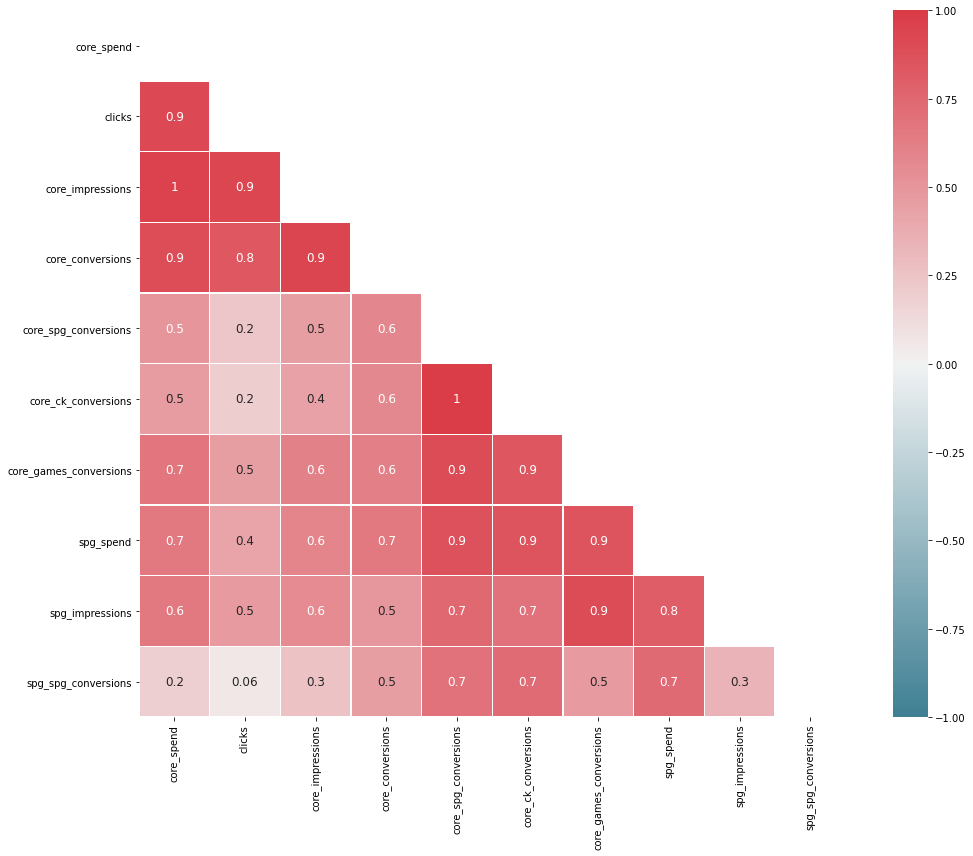

In [117]:
get_corr_matrix(df_core_qtr, var_list=df_core_qtr.columns, start=df_core_qtr.index.min(), end=df_core_qtr.index.max())

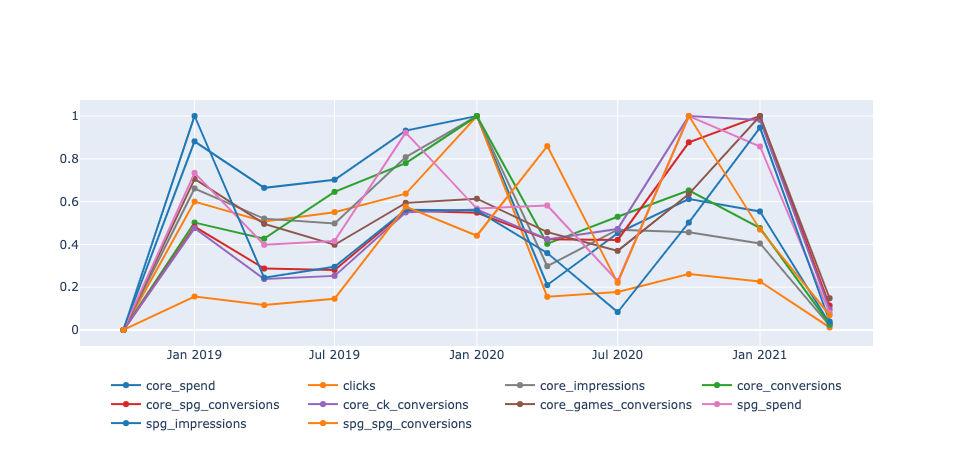

In [118]:
plot_variables(df_core_qtr, df_core_qtr.columns, one_plot=True, scaled=True)

### Monthly

In [122]:
#create monthly view of impressions, core starts, spg starts
df_core_mnth = df_core.groupby('year_month_cal')['spend','impressions', 'clicks', 'core_conversions','spg_conversions',
                                         'ck_conversions','games_conversions'].sum()

#rename cols
df_core_mnth.rename(columns = {'spend':'core_spend', 
                           'impressions':'core_impressions', 
                             'spg_conversions':'core_spg_conversions', 
                             'ck_conversions':'core_ck_conversions',
                             'games_conversions':'core_games_conversions'},
                   inplace=True)

#add in SPG impression, conversion, data
df_spg_mnth = spg_df.groupby('year_month_cal')['spend','impressions','spg_conversions'].sum()
df_spg_mnth.rename(columns = {'spend':'spg_spend',
                        'impressions':'spg_impressions', 
                            'spg_conversions':'spg_spg_conversions'},
                  inplace=True)

df_core_mnth = df_core_mnth.merge(df_spg_mnth, left_index=True, right_index=True)

<ipython-input-122-e25bd20e9727>:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

<ipython-input-122-e25bd20e9727>:14: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



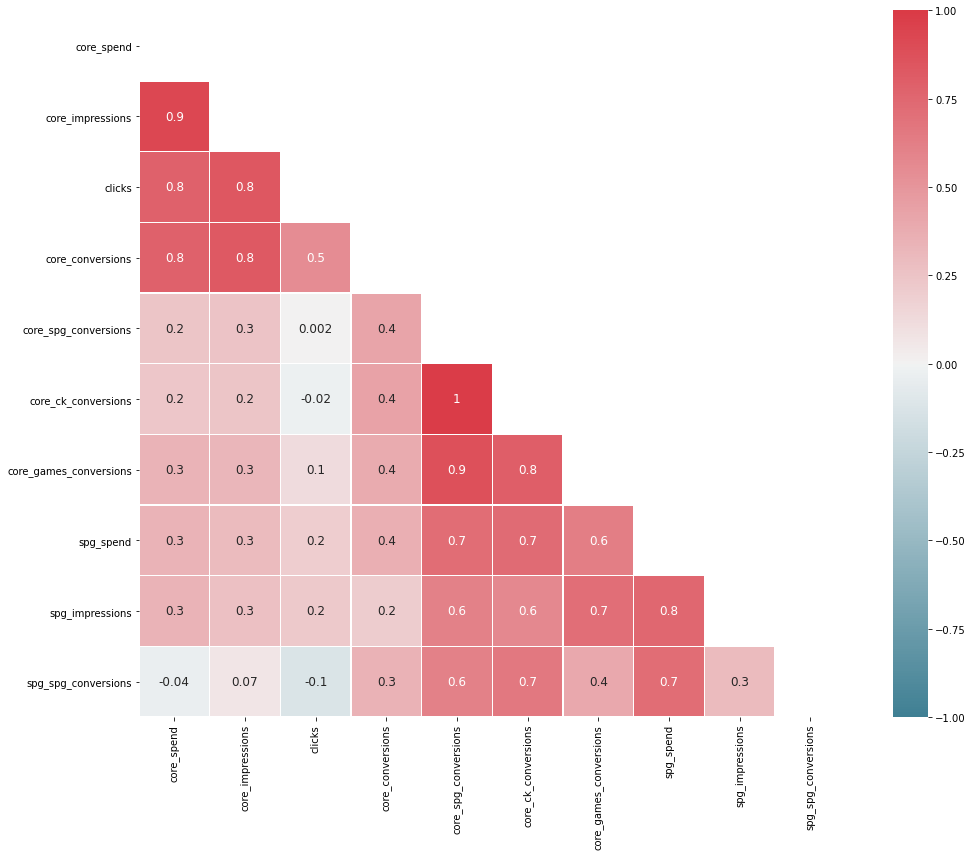

In [123]:
get_corr_matrix(df_core_mnth, var_list=df_core_mnth.columns, start=df_core_mnth.index.min(), end=df_core_mnth.index.max())

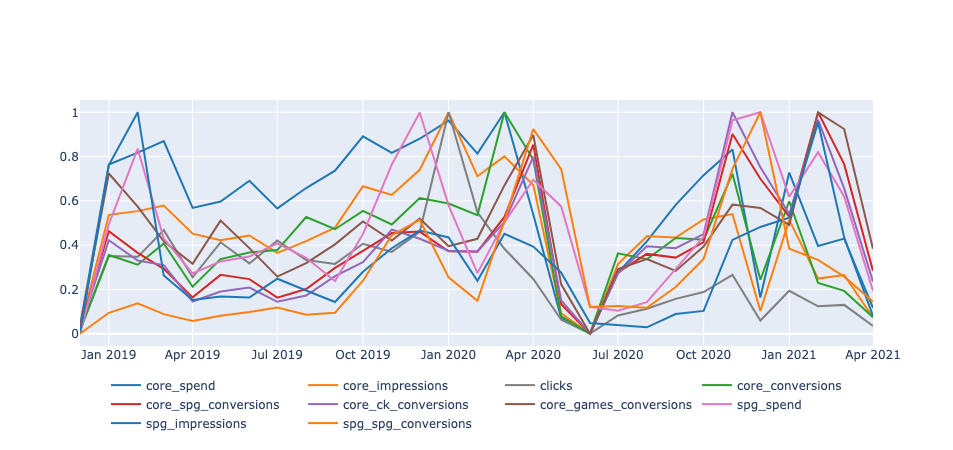

In [124]:
plot_variables(df_core_mnth, df_core_mnth.columns, one_plot=True, scaled=True)

### Weekly

In [125]:
#create monthly view of impressions, core starts, spg starts
df_core_wk = df_core.groupby('year_week_monday')['spend','impressions', 'clicks', 'core_conversions','spg_conversions',
                                         'ck_conversions','games_conversions'].sum()

#rename cols
df_core_wk.rename(columns = {'spend':'core_spend', 
                           'impressions':'core_impressions', 
                             'spg_conversions':'core_spg_conversions', 
                             'ck_conversions':'core_ck_conversions',
                             'games_conversions':'core_games_conversions'},
                   inplace=True)

#add in SPG impression, conversion, data
df_spg_wk = spg_df.groupby('year_week_monday')['spend','impressions','spg_conversions'].sum()
df_spg_wk.rename(columns = {'spend':'spg_spend',
                        'impressions':'spg_impressions', 
                            'spg_conversions':'spg_spg_conversions'},
                  inplace=True)

df_core_wk = df_core_wk.merge(df_spg_wk, left_index=True, right_index=True)

<ipython-input-125-75ace4e9afe0>:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

<ipython-input-125-75ace4e9afe0>:14: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



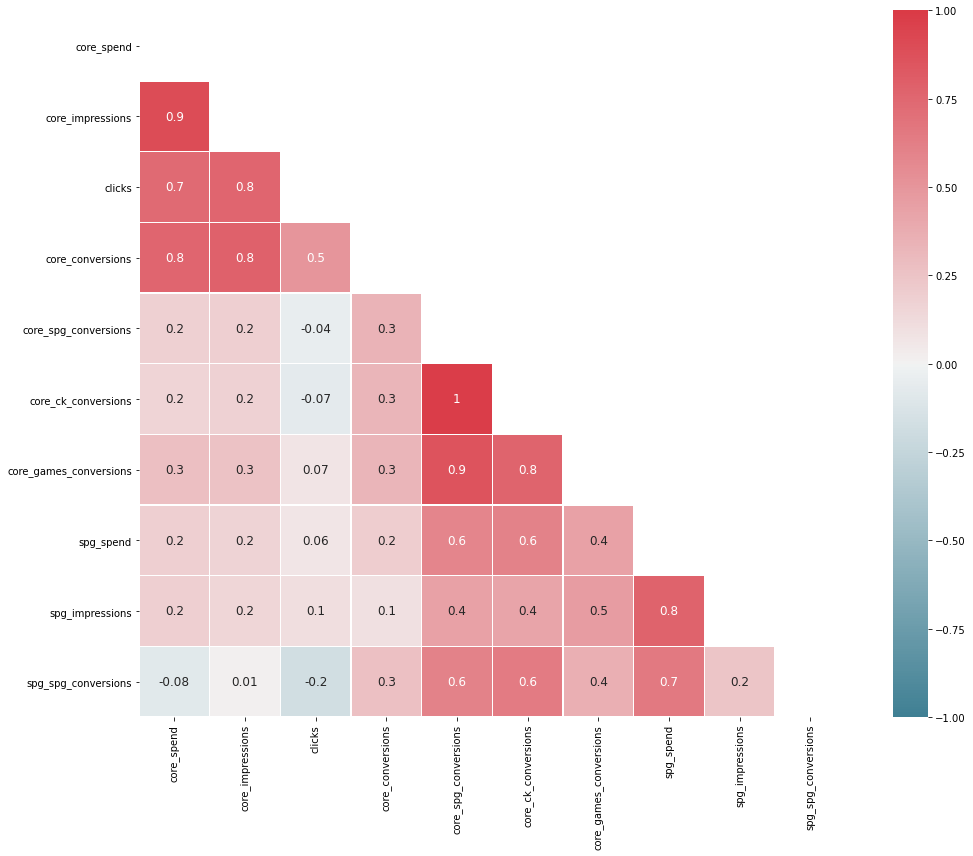

In [126]:
get_corr_matrix(df_core_wk, var_list=df_core_wk.columns, start=df_core_wk.index.min(), end=df_core_wk.index.max())

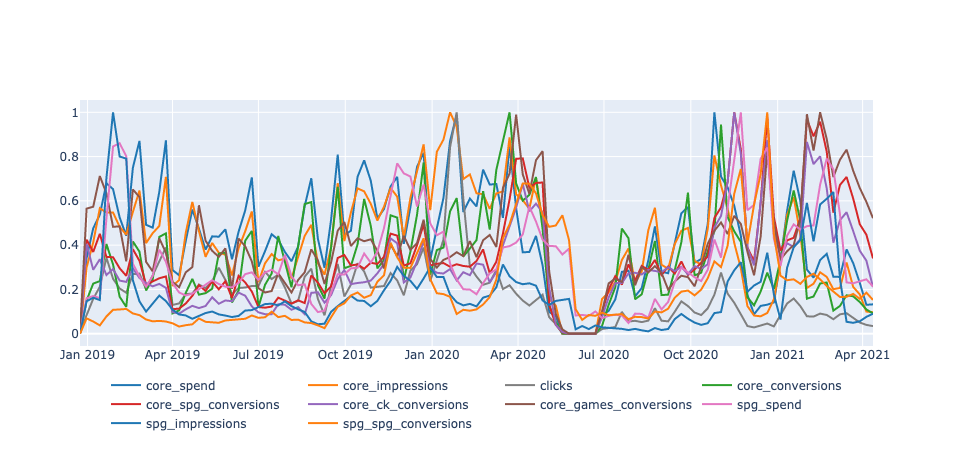

In [127]:
plot_variables(df_core_wk, df_core_wk.columns, one_plot=True, scaled=True)

In [134]:
df_core[df_core['marketing_initiative'].isin(['Brand','Branding'])][['core_conversions','spg_conversions']].sum()

core_conversions    16427.0
spg_conversions      1226.0
dtype: float64

In [135]:
df_core[~df_core['marketing_initiative'].isin(['Brand','Branding'])][['core_conversions','spg_conversions']].sum()

core_conversions    1.437229e+06
spg_conversions     5.949374e+04
dtype: float64

### Daily

In [140]:
#create monthly view of impressions, core starts, spg starts
df_core_daily = df_core.groupby('date')['spend','impressions', 'clicks', 'core_conversions','spg_conversions',
                                         'ck_conversions','games_conversions'].sum()

#rename cols
df_core_daily.rename(columns = {'spend':'core_spend', 
                           'impressions':'core_impressions', 
                                'clicks':'core_clicks', 
                             'spg_conversions':'core_spg_conversions', 
                             'ck_conversions':'core_ck_conversions',
                             'games_conversions':'core_games_conversions'},
                   inplace=True)

#add in SPG impression, conversion, data
df_spg_daily = spg_df.groupby('date')['spend','impressions','spg_conversions'].sum()
df_spg_daily.rename(columns = {'spend':'spg_spend',
                        'impressions':'spg_impressions', 
                            'spg_conversions':'spg_spg_conversions'},
                  inplace=True)

df_core_daily = df_core_daily.merge(df_spg_daily, left_index=True, right_index=True)

<ipython-input-140-6694e58d5961>:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

<ipython-input-140-6694e58d5961>:15: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



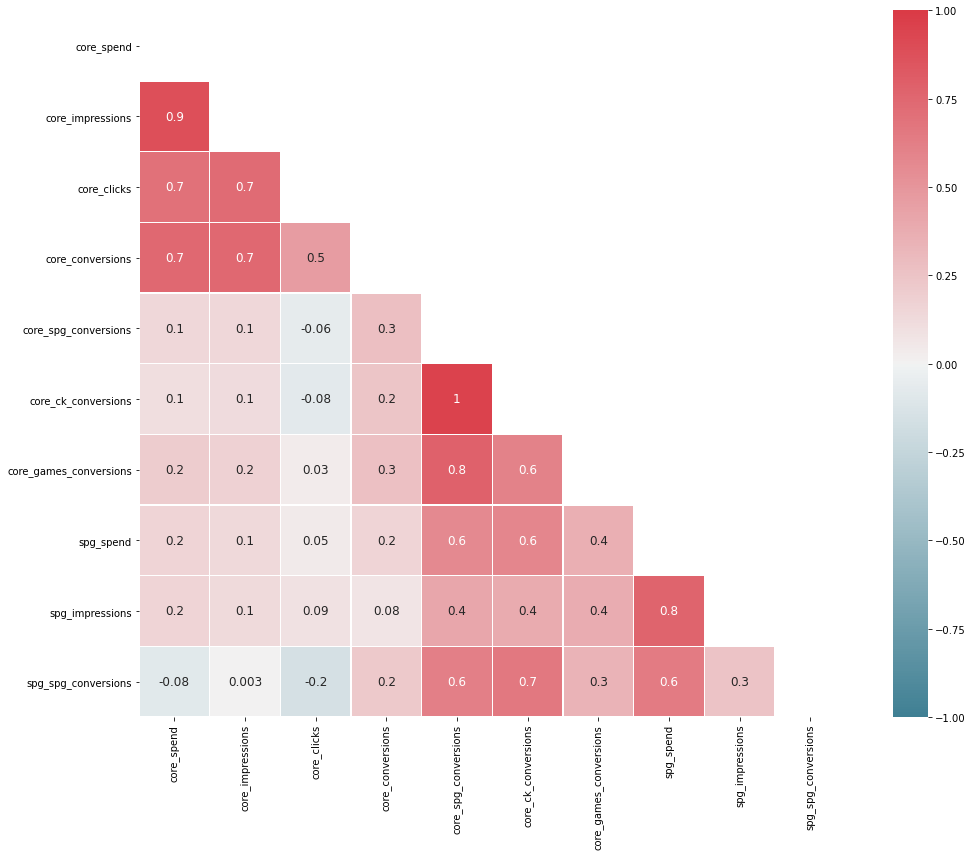

In [141]:
get_corr_matrix(df_core_daily, var_list=df_core_daily.columns, start=df_core_daily.index.min(), end=df_core_daily.index.max())

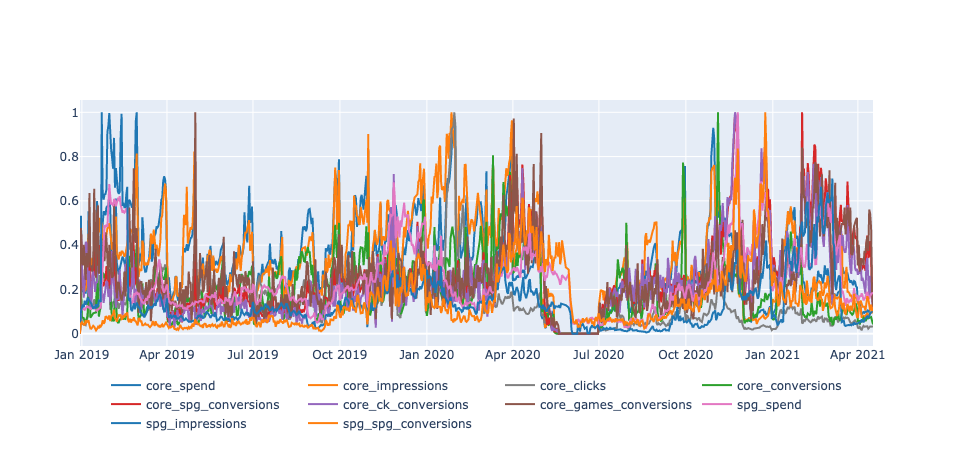

In [142]:
plot_variables(df_core_daily, df_core_daily.columns, one_plot=True, scaled=True)

# 2. look for more granular correlations

In [ ]:
correls_df = df_core.groupby(['year_month_cal','year_week_iso','date','channel_mkt_init']).sum().reset_index()
correls_df = correls_df.pivot(index='date', columns='channel_mkt_init', values=['clicks','impressions','games_conversions','ck_conversions', 'spg_conversions'])

correls_df.columns = ['_'.join(col).strip() for col in correls_df.columns.values]

In [ ]:
correls_df.columns = correls_df.columns.str.replace(' - ','_').str.replace('/','').str.replace(' ', '')

In [ ]:
df_core['channel'].unique()

In [ ]:
correls_df[[col for col in correls_df.columns if 'Native' in col and 'ck_conversions' not in col and 'games_conversions' not in col]].corr()

In [ ]:
plot_variables(correls_df, ['clicks_Native_Sale','impressions_Native_Sale','spg_conversions_Native_Sale'], one_plot=True, scaled=True)

# 2 Try regression - with all data and impression volumes across channel_mkt_init

__construct impressions, clicks, and starts columns__

In [ ]:
reg_df = df_core.groupby(['date','channel_mkt_init'])['clicks','impressions','spend','core_conversions','spg_conversions'].sum().reset_index()

In [ ]:
reg_df = reg_df.pivot(index='date', columns='channel_mkt_init', values=['clicks','impressions','spend','core_conversions','spg_conversions'])

In [ ]:
reg_df.columns = reg_df.columns = ['_'.join(col).strip() for col in reg_df.columns.values]

In [ ]:
reg_df.fillna(0, inplace=True)

In [ ]:
reg_df.reset_index(inplace=True)
reg_df['date'] = reg_df['date'].astype('datetime64[ns]')

In [ ]:
reg_df['spg_conversions_all'] = reg_df[[col for col in reg_df.columns if 'spg_conversions' in col]].sum(axis=1)

In [ ]:
#create month and weekday cols for dummies
reg_df['weekday'] = reg_df['date'].apply(lambda x: x.strftime('%A'))
reg_df['month'] = reg_df['date'].dt.month_name()

#create a merge dummies 
reg_df = pd.concat([reg_df, 
               pd.get_dummies(reg_df['weekday'], prefix='weekday'), 
               pd.get_dummies(reg_df['month'], prefix='month')], axis=1)

__add spg impressions, spend information__

In [ ]:
#create reg_dfs from main data pull with only cooking and games data

cooking_reg_df = df[(df['marketing_subinitiative'].isin(['Cooking'])) & 
                     ~(df['campaign'].str.contains('app')) & 
                    (df['attr_window'] == 'Combined')]

games_reg_df = df[(df['marketing_subinitiative'].isin(['Games'])) & 
                     ~(df['campaign'].str.contains('app')) & 
                    (df['attr_window'] == 'Combined')]

In [ ]:
#clean up date col
cooking_reg_df['date'] = cooking_reg_df['date'].astype('datetime64[ns]')
games_reg_df['date'] = games_reg_df['date'].astype('datetime64[ns]')

In [ ]:
#group cooking and games reg_dfs to daily spend, impressions + rename cols
cooking_daily = cooking_reg_df.groupby('date')[['impressions','spend']].sum().reset_index().rename(columns={'impressions':'ck_impressions',
                                                                                       'spend':'ck_spend'})
games_daily = games_reg_df.groupby('date')[['impressions','spend']].sum().reset_index().rename(columns={'impressions':'games_impressions',
                                                                                       'spend':'games_spend'})

In [ ]:
#merge cooking and games info into reg_df that we'll use for regression
reg_df = reg_df.merge(cooking_daily, how='left', on='date')
reg_df = reg_df.merge(games_daily, how='left', on='date')

In [ ]:
#fill NA with 0
reg_df.fillna(0, inplace=True)

In [ ]:
#set index as date
reg_df.set_index('date', inplace=True)

In [ ]:
indep_vars = [col for col in reg_df.columns if 'impressions' in col and 'Brand' not in col and 'UNKNOWN' not in col] + \
[col for col in reg_df.columns if 'month_' in col]
# [col for col in reg_df.columns if 'weekday_' in col] + \
# [col for col in reg_df.columns if 'core_conversions' in col]

In [ ]:
X = reg_df[indep_vars]
y = reg_df[['spg_conversions_all']]

#### optional: try grouping by week to reduce noise

In [ ]:
X.reset_index(inplace=True)
y.reset_index(inplace=True)

X['year_week_monday'] = X['date'].dt.to_period('W').apply(lambda r: r.start_time)
y['year_week_monday'] = y['date'].dt.to_period('W').apply(lambda r: r.start_time)

In [ ]:
X = X.groupby('year_week_monday').agg({'ck_impressions':'sum',
                                 'games_impressions':'sum',
                                 'impressions_Display - Business As Usual':'sum',
                                 'impressions_Display - Content/Audience Development':'sum',
                                 'impressions_Display - Engagement':'sum',
                                 'impressions_Display - Gifting':'sum',
                                 'impressions_Display - One Day Sale':'sum',
                                 'impressions_Display - Sale':'sum',
                                 'impressions_Display - Testing':'sum',
                                 'impressions_Display - X-UNKNOWN-X':'sum',
                                 'impressions_Native - Business As Usual':'sum',
                                 'impressions_Native - Content/Audience Development':'sum',
                                 'impressions_Native - Gifting':'sum',
                                 'impressions_Native - One Day Sale':'sum',
                                 'impressions_Native - Sale':'sum',
                                 'impressions_Other - Business As Usual':'sum',
                                 'impressions_Other - Content/Audience Development':'sum',
                                 'impressions_Paid Search - Business As Usual':'sum',
                                 'impressions_Paid Search - Content/Audience Development':'sum',
                                 'impressions_Paid Search - Engagement':'sum',
                                 'impressions_Paid Search - Gifting':'sum',
                                 'impressions_Paid Search - One Day Sale':'sum',
                                 'impressions_Paid Search - Retention':'sum',
                                 'impressions_Paid Search - Sale':'sum',
                                 'impressions_Social - App-Install':'sum',
                                 'impressions_Social - Audience Content':'sum',
                                 'impressions_Social - Business As Usual':'sum',
                                 'impressions_Social - Content/Audience Development':'sum',
                                 'impressions_Social - DR and Content Combined':'sum',
                                 'impressions_Social - Gifting':'sum',
                                 'impressions_Social - One Day Sale':'sum',
                                 'impressions_Social - Sale':'sum',
                                 'impressions_Social - X-UNKNOWN-X':'sum',
                                 'impressions_Video - Business As Usual':'sum',
                                 'impressions_Video - One Day Sale':'sum',
                                 'impressions_Video - Sale':'sum',
                                 'impressions_X-UNKNOWN-X - Business As Usual':'sum',
                                 'impressions_X-UNKNOWN-X - Content/Audience Development':'sum',
                                 'impressions_Youtube - Content/Audience Development':'sum',
                                 'impressions_Youtube - X-UNKNOWN-X':'sum',
                                 'month_April':'max',
                                 'month_August':'max',
                                 'month_December':'max',
                                 'month_February':'max',
                                 'month_January':'max',
                                 'month_July':'max',
                                 'month_June':'max',
                                 'month_March':'max',
                                 'month_May':'max',
                                 'month_November':'max',
                                 'month_October':'max',
                                 'month_September':'max'
                               })

y = y.groupby('year_week_monday').sum()

In [ ]:
# scaler = MinMaxScaler()
# scaled = scaler.fit_transform(X)

# X = pd.DataFrame(data=scaled, columns=X.columns)
# X['date'] = reg_df_reg.index.values
# X.set_index('date', inplace=True)

# y['date'] = reg_df_reg.index.values
# y.set_index('date', inplace=True)

In [ ]:
X = sm.add_constant(X)

ols_test = sm.OLS(y, X).fit() 

ols_test.summary()

In [ ]:
ols_y_pred = ols_test.predict(X)

ols_vis = X.copy()
ols_vis['y_pred'] = ols_y_pred
ols_vis['y_actual'] = y

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ols_vis.index, y=ols_vis['y_pred'],
                    mode='lines',
                    name='spg_convs_predicted'))
fig.add_trace(go.Scatter(x=ols_vis.index, y=ols_vis['y_actual'],
                    mode='lines',
                    name='spg_convs_actual'))

fig.show()

__Try holding out the last few months__

In [ ]:
is_s = '2019-01-01'
is_e = '2020-12-31'

oos_s = '2021-01-01'
oos_e = '2021-04-01'

X_train = X.loc[is_s:is_e]
X_test = X.loc[oos_s:oos_e]

y_train = y.loc[is_s:is_e]
y_test = y.loc[oos_s:oos_e]

In [ ]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)


ols = sm.OLS(y_train, X_train).fit() 

ols.summary()

In [ ]:
#####################################
# TRAIN
######################################

train_ols_y_pred = ols.predict(X_train)

train_ols_vis = X_train.copy()
train_ols_vis['y_pred'] = train_ols_y_pred
train_ols_vis['y_actual'] = y_train

#####################################
# TEST
######################################
test_ols_y_pred = ols.predict(X_test)

test_ols_vis = X_test.copy()
test_ols_vis['y_pred'] = test_ols_y_pred
test_ols_vis['y_actual'] = y_test

######################################
# COMBINE
######################################

ols_vis = pd.concat([train_ols_vis,test_ols_vis])

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ols_vis.index, y=ols_vis['y_pred'],
                    mode='lines',
                    name='spg_conversions_predicted'))
fig.add_trace(go.Scatter(x=ols_vis.index, y=ols_vis['y_actual'],
                    mode='lines',
                    name='spg_conversions_actual'))

fig.show()

In [ ]:
ols_vis['all_core_impressions'] = ols_vis[[col for col in ols_vis.columns if 'impressions' in col and 'games' not in col and 'ck_' not in col]].sum(axis=1)

In [ ]:
plot_variables(ols_vis, ['games_impressions','ck_impressions','all_impressions','y_pred','y_actual'], one_plot=True, scaled=True)

__Try Stepwise__

In [ ]:
import statsmodels.formula.api as smf


def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    i = 1
    while remaining and current_score == best_new_score:
        print(f"Iteration: {i}")
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
            print("New best model found")
            print(formula)
        i += 1
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [ ]:
stepwise_df = reg_df[is_s:is_e][indep_vars + ['spg_conversions_all']]

In [ ]:
stepwise_df.head()

In [ ]:
stepwise_df.columns = stepwise_df.columns.str.replace(' ', '')
stepwise_df.columns = stepwise_df.columns.str.replace('-','_')
stepwise_df.columns = stepwise_df.columns.str.replace('/','_')

In [ ]:
formula = "spg_conversions_all ~ ck_impressions + games_impressions + impressions_Display_Sale + impressions_Social_BusinessAsUsual + impressions_PaidSearch_Sale + month_June + month_April + impressions_PaidSearch_Gifting + impressions_Display_Gifting + month_May + impressions_Native_Content_AudienceDevelopment + impressions_Social_Gifting + impressions_Social_Content_AudienceDevelopment + impressions_PaidSearch_BusinessAsUsual + impressions_Display_Testing + month_March + month_July + impressions_Social_X_UNKNOWN_X + impressions_Display_BusinessAsUsual + impressions_Display_Content_AudienceDevelopment + 1"
stepwise_model = smf.ols(formula, stepwise_df).fit()

In [ ]:
stepwise_model.summary()

In [ ]:
stepwise_df_test = reg_df[oos_s:oos_e][indep_vars]

stepwise_df_test.columns = stepwise_df_test.columns.str.replace(' ', '')
stepwise_df_test.columns = stepwise_df_test.columns.str.replace('-','_')
stepwise_df_test.columns = stepwise_df_test.columns.str.replace('/','_')

stepwise_df_train = reg_df[is_s:is_e][indep_vars]

stepwise_df_train.columns = stepwise_df_train.columns.str.replace(' ', '')
stepwise_df_train.columns = stepwise_df_train.columns.str.replace('-','_')
stepwise_df_train.columns = stepwise_df_train.columns.str.replace('/','_')

In [ ]:
#####################################
# TRAIN
######################################

stepwise_train_y_pred = stepwise_model.predict(stepwise_df_train)
stepwise_df_train['y_pred'] = stepwise_train_y_pred
stepwise_df_train['y_actual'] = reg_df[is_s:is_e]['spg_conversions_all']

#####################################
# TEST
######################################
stepwise_test_y_pred = stepwise_model.predict(stepwise_df_test)
stepwise_df_test['y_pred'] = stepwise_test_y_pred
stepwise_df_test['y_actual'] = reg_df[oos_s:oos_e]['spg_conversions_all']

######################################
# COMBINE
######################################

stepwise_vis = pd.concat([stepwise_df_train,stepwise_df_test])

In [ ]:
plot_variables(stepwise_vis, ['y_pred','y_actual'], one_plot=True, scaled=False)

# 3. Capture basic info on cross-sell (Cooking Only)

# 3.1 Identify cross-sell patterns (CK)

__Look at volumes__

In [ ]:
mkt_init_vol = df_core.groupby(['marketing_initiative'])['impressions', 'ck_conversions'].sum().sort_values('ck_conversions', ascending=False)
mkt_init_vol.reset_index(inplace=True)
mkt_init_vol['impression_weights'] = mkt_init_vol['impressions'] / mkt_init_vol['ck_conversions']
mkt_init_vol

In [ ]:
mkt_init_vol.sort_values('impression_weights', ascending=True)

Sale, Content/Audience Dev, and BAU make up the vast majority of CK cross sells. However, this is mostly because of sheer impression volume. The most efficient tactics are those with the lowest impression weights - Testing, Gifting, Audience Content, Content/Audience Dev.

In [ ]:
channel_vol = df_core.groupby(['channel'])['impressions','ck_conversions'].sum().sort_values('ck_conversions', ascending=False)
channel_vol.reset_index(inplace=True)
channel_vol['impression_weights'] = channel_vol['impressions'] / channel_vol['ck_conversions']
channel_vol

In [ ]:
channel_vol.sort_values('impression_weights', ascending=True).head(5)

Display, Native and Social drove the most cross-sells. But Paid Search drove the most efficient cross-sells.

In [ ]:
channel_mkt_vol = df_core.groupby('channel_mkt_init')['impressions','ck_conversions'].sum().sort_values('ck_conversions',ascending=False)
channel_mkt_vol.reset_index(inplace=True)
channel_mkt_vol['impression_weights'] = channel_mkt_vol['impressions'] / channel_mkt_vol['ck_conversions']
channel_mkt_vol.head(10)

In [ ]:
channel_mkt_vol.sort_values('impression_weights', ascending=True).head(10)

Various Paid Search and Display tactics drove the most efficient cross-sell results. Meanwhile, Display Social and Native (Sale and Content/Audience Dev) drove the highest volume of cross-sells.

__Look at correlations__

In [ ]:
#create monthly view
df_core_monthly = df_core.groupby(['year_month_cal','channel_mkt_init'])[['clicks','impressions','games_conversions','ck_conversions']].sum().reset_index()

#pivot to only have only one row per month
df_core_monthly = df_core_monthly.pivot(index='year_month_cal', columns='channel_mkt_init', values=['clicks','impressions','games_conversions','ck_conversions'])

In [ ]:
#flatten index
df_core_monthly.columns = df_core_monthly.columns.to_flat_index()

In [ ]:
#create one aggregate ck starts column for simpler correlations
df_core_monthly['ck_conversions_all'] = df_core_monthly[[col for col in df_core_monthly.columns if 'ck_conversions' in col]].sum(axis=1)

In [ ]:
#start with just impressions and ck conversions
ck_imps_monthly = df_core_monthly[[col for col in df_core_monthly.columns if 'impressions' in col] + ['ck_conversions_all']]

In [ ]:
#replace nans with 0 because it means there were no impressions in that period
ck_imps_monthly.fillna(0, inplace=True)

In [ ]:
#get correlations between ck starts and impression volumes
ck_convs_imps_corr = ck_imps_monthly.corrwith(ck_imps_monthly['ck_conversions_all']).to_frame().rename(columns={0:'corr_with_ck_conv'}).reset_index()

#sort the frame
ck_convs_imps_corr.sort_values('corr_with_ck_conv', ascending=False, inplace=True)

In [ ]:
ck_convs_imps_corr.head(20)

Based on the above correlation chart, it seems that __sales__ have the strongest relationship with cross-sell starts. Major channels such as Paid Search, Display, Native, and Social show the highest correlation. That said, the highest correlation by far is Paid Search - Sale; other channels have modest relationships with CK conversions (~.50 or less)

This preliminary analysis would indicate that sale-based Core media does the best job attracting Cooking starts.

Social - Audience/Content also seems to do a fairly good job generating CK starts.

# 3.2 Try a Regression (CK)

cols to try: 
* campaign_objective
* marketing_initiative
* marketing_segment
* channel
* platform
* impressions
* core_conversions
* month dummy

In [ ]:
#reduce number of cols 
df_reg = df_core[(df_core['channel'].isin(['Display','Native','Social','Paid Search'])) & 
                (df_core['marketing_initiative'].isin(['Sale','Content/Audience Development','Business As Usual','One Day Sale']))].groupby(['date','channel','marketing_initiative'])[['impressions','core_conversions','ck_conversions']].sum().reset_index()

In [ ]:
df_reg.groupby(['date'])[['impressions','core_conversions','ck_conversions']].sum().corr()

In [ ]:
#create month and weekday cols for dummies
df_reg['weekday'] = df_reg['date'].apply(lambda x: x.strftime('%A'))
df_reg['month'] = df_reg['date'].dt.month_name()

#create a merge dummies 
df_reg = pd.concat([df_reg, 
                  pd.get_dummies(df_reg['channel'], prefix='channel'),
                 pd.get_dummies(df_reg['marketing_initiative'], prefix='mkt_init'), 
               pd.get_dummies(df_reg['weekday'], prefix='weekday'), 
               pd.get_dummies(df_reg['month'], prefix='month')], axis=1)

#drop old cols and set index to date
df_reg.drop(['channel','marketing_initiative','weekday','month'], axis=1, inplace=True)
df_reg.set_index('date', inplace=True)

# #add some holiday dummies for cooking 
# df_reg['xmas'] = 0
# df_reg.loc['2020-12-20':'2020-12-25', 'xmas'] = 1

# df_reg['thanksgiving'] = 0
# df_reg.loc['2020-11-22':'2020-11-25', 'thanksgiving'] = 1


In [ ]:
df_reg = df_reg.groupby('date').agg({'impressions': 'sum',
                            'core_conversions':'sum',
                            'ck_conversions':'sum',
                            'channel_Display':'max',
                             'channel_Native':'max',
                             'channel_Paid Search':'max',
                             'channel_Social':'max',
                             'mkt_init_Business As Usual':'max',
                             'mkt_init_Content/Audience Development':'max',
                             'mkt_init_One Day Sale':'max',
                             'mkt_init_Sale':'max',
                             'month_April':'max',
                             'month_August':'max',
                             'month_December':'max',
                             'month_February':'max',
                             'month_January':'max',
                             'month_July':'max',
                             'month_June':'max',
                             'month_March':'max',
                             'month_May':'max',
                             'month_November':'max',
                             'month_October':'max',
                             'month_September':'max',
                             'weekday_Friday':'max',
                             'weekday_Monday':'max',
                             'weekday_Saturday':'max',
                             'weekday_Sunday':'max',
                             'weekday_Thursday':'max',
                             'weekday_Tuesday':'max',
                             'weekday_Wednesday':'max'})

In [ ]:
X = df_reg.drop('ck_conversions', axis=1)
y = df_reg[['ck_conversions']]

In [ ]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(X)

X = pd.DataFrame(data=scaled, columns=X.columns)
X['date'] = df_reg.index.values
X.set_index('date', inplace=True)

y['date'] = df_reg.index.values
y.set_index('date', inplace=True)

In [ ]:
X = sm.add_constant(X)

ols_test = sm.OLS(y, X).fit() 

ols_test.summary()

In [ ]:
ols_y_pred = ols_test.predict(X)

ols_vis = X.copy()
ols_vis['y_pred'] = ols_y_pred
ols_vis['y_actual'] = y

ols_daily = ols_vis.reset_index().groupby('date').sum()


fig = go.Figure()
fig.add_trace(go.Scatter(x=ols_daily.index, y=ols_daily['y_pred'],
                    mode='lines',
                    name='ck_conversions_predicted'))
fig.add_trace(go.Scatter(x=ols_daily.index, y=ols_daily['y_actual'],
                    mode='lines',
                    name='ck_conversions_actual'))
fig.add_trace(go.Scatter(x=ols_daily.index, y=ols_daily['impressions'],
                    mode='lines',
                    name='total_core_impressions'))

fig.show()

__Scaled version of residuals plot__

In [ ]:
plot_scaler = MinMaxScaler()
plot_scaled = plot_scaler.fit_transform(ols_daily)


plot_daily = pd.DataFrame(data=plot_scaled, columns=ols_daily.columns)
plot_daily['date'] = ols_daily.index.values
plot_daily.set_index('date', inplace=True)

fig = go.Figure()
fig.add_trace(go.Scatter(x=plot_daily.index, y=plot_daily['y_pred'],
                    mode='lines',
                    name='ck_conversions_predicted'))
fig.add_trace(go.Scatter(x=plot_daily.index, y=plot_daily['y_actual'],
                    mode='lines',
                    name='ck_conversions_actual'))
fig.add_trace(go.Scatter(x=plot_daily.index, y=plot_daily['impressions'],
                    mode='lines',
                    name='total_core_impressions'))

fig.show()

The initial pass was garbage. There are likely several reasons for this, but first and foremost is that we have too many independent variables, too few observations which include those independent variables, and independent variables that have little to no relationship with our dependent (in this case, Cooking starts). 

To refine the regression approach we need to do more EDA to understand which channels and tactics have the most explanatory power.

__NOTE: CK conversions drop to near zero in May through July, and also have major spikes around Thanksgiving and Xmas. Cooking media went dark in May through July, and also has the heaviest spend around the aforementioned holidays. The absence of Cooking starts during the dark period and the holiday spikes could indicate that these Cooking "cross sell" starts are really being driven by Cooking media, and the audiences also happened to be served Core ads which greedily picked up the credit. Need to explore this further - very important caveat to this analysis__

__Critical open question:__
* How do we remove the influence of Cooking/Games paid media that ran concurrently with Core paid media?

One possible solution could be to __only include click-through cross-sell conversions__ in this analysis. That way we can be a little more sure that it was, in fact, the Core ad that generated the CK or Games conversion. This would be a more conservative approach, but would mitigate the risk that we go on to calculate a blended CPO based on misattributed viewthrough conversions.

### Try two model improvements, separately: 

#### A) just look at click-thru conversions
#### B) add in CK spend/impressions to regression and see how it correlates / comes into the model 

In [ ]:
ck_daily = df[(df['marketing_subinitiative'] == 'Cooking') & 
  (df['attr_window'] == 'Media Reported') & 
  (df['marketing_initiative'] != 'App Download') & 
  ~(df['campaign'].str.contains('app'))]

ck_daily['date'] = ck_daily['date'].astype('datetime64[ns]')

ck_daily = ck_daily.groupby('date').sum().reset_index()

In [ ]:
ck_daily.rename(columns = {'impressions':'ck_impressions',
                          'spend':'ck_spend'}, inplace=True)

In [ ]:
df_reg.reset_index(inplace=True)
df_reg['date'] = df_reg['date'].astype('datetime64[ns]')

In [ ]:
df_reg = df_reg.merge(ck_daily[['date','ck_impressions']], how='left', on='date').fillna(0)
df_reg.set_index('date', inplace=True)

In [ ]:
X = df_reg.drop('ck_conversions', axis=1)
y = df_reg[['ck_conversions']]

In [ ]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(X)

X = pd.DataFrame(data=scaled, columns=X.columns)
X['date'] = df_reg.index.values
X.set_index('date', inplace=True)

y['date'] = df_reg.index.values
y.set_index('date', inplace=True)

In [ ]:
X = sm.add_constant(X)

ols_test = sm.OLS(y, X).fit() 

ols_test.summary()

In [ ]:
plot_scaler = MinMaxScaler()
plot_scaled = plot_scaler.fit_transform(ols_daily)


plot_daily = pd.DataFrame(data=plot_scaled, columns=ols_daily.columns)
plot_daily['date'] = ols_daily.index.values
plot_daily.set_index('date', inplace=True)

fig = go.Figure()
fig.add_trace(go.Scatter(x=plot_daily.index, y=plot_daily['y_pred'],
                    mode='lines',
                    name='ck_conversions_predicted'))
fig.add_trace(go.Scatter(x=plot_daily.index, y=plot_daily['y_actual'],
                    mode='lines',
                    name='ck_conversions_actual'))
fig.add_trace(go.Scatter(x=plot_daily.index, y=plot_daily['impressions'],
                    mode='lines',
                    name='total_core_impressions'))
fig.add_trace(go.Scatter(x=plot_daily.index, y=plot_daily['ck_impressions'],
                    mode='lines',
                    name='ck_impressions'))

fig.show()

# APPENDIX

In [222]:
reg_df = df_core.groupby(['date','channel'])[['clicks','impressions',
                                                      'spend','core_conversions',
                                                      'ck_conversions']].sum().reset_index()

In [223]:
reg_df = reg_df.pivot(index='date', 
                      columns='channel', 
                      values=['clicks','impressions','spend','core_conversions','ck_conversions'])

In [224]:
reg_df.columns = reg_df.columns = ['_'.join(col).strip() for col in reg_df.columns.values]

In [225]:
reg_df.fillna(0, inplace=True)

In [226]:
reg_df.reset_index(inplace=True)
reg_df['date'] = reg_df['date'].astype('datetime64[ns]')

In [227]:
reg_df['core_ck_conversions_all'] = reg_df[[col for col in reg_df.columns if 'ck_conversions' in col]].sum(axis=1)
reg_df['core_core_conversions_all'] = reg_df[[col for col in reg_df.columns if 'core_conversions' in col]].sum(axis=1)

In [228]:
#create month and weekday cols for dummies
reg_df['weekday'] = reg_df['date'].apply(lambda x: x.strftime('%A'))
reg_df['month'] = reg_df['date'].dt.month_name()

#create a merge dummies 
reg_df = pd.concat([reg_df, 
               pd.get_dummies(reg_df['weekday'], prefix='weekday'), 
               pd.get_dummies(reg_df['month'], prefix='month')], axis=1)

__add spg impressions, spend information__

In [229]:
#create reg_dfs from main data pull with only cooking and games data

cooking_reg_df = df[(df['marketing_subinitiative'].isin(['Cooking'])) & 
                     ~(df['campaign'].str.contains('app')) & 
                    (df['attr_window'] == 'Combined')]

# games_reg_df = df[(df['marketing_subinitiative'].isin(['Games'])) & 
#                      ~(df['campaign'].str.contains('app')) & 
#                     (df['attr_window'] == 'Combined')]

In [230]:
#clean up date col
cooking_reg_df['date'] = cooking_reg_df['date'].astype('datetime64[ns]')
# games_reg_df['date'] = games_reg_df['date'].astype('datetime64[ns]')

In [231]:
#group cooking and games reg_dfs to daily spend, impressions + rename cols
cooking_daily = cooking_reg_df.groupby('date')[['impressions','spend', 'ck_conversions']].sum().reset_index().rename(columns={'impressions':'ck_impressions',
                                                                                       'spend':'ck_spend',
                                                                                        'ck_conversions':'ck_ck_conversions'})
# games_daily = games_reg_df.groupby('date')[['impressions','spend']].sum().reset_index().rename(columns={'impressions':'games_impressions',
#                                                                                        'spend':'games_spend'})

In [232]:
#merge cooking and games info into reg_df that we'll use for regression
reg_df = reg_df.merge(cooking_daily, how='left', on='date')
# reg_df = reg_df.merge(games_daily, how='left', on='date')

In [233]:
#fill NA with 0
reg_df.fillna(0, inplace=True)

In [234]:
#set index as date
reg_df.set_index('date', inplace=True)

In [235]:
indep_vars = [col for col in reg_df.columns if 'impressions' in col and 'Brand' not in col and 'UNKNOWN' not in col] + \
[col for col in reg_df.columns if 'month_' in col] + \
[col for col in reg_df.columns if 'weekday_' in col] + \
['ck_spend', 'core_core_conversions_all', 'ck_ck_conversions']
# [col for col in reg_df.columns if 'core_conversions' in col] + \


In [236]:
X = reg_df[indep_vars]
y = reg_df[['core_ck_conversions_all']]

In [237]:
X = sm.add_constant(X)

ols_test = sm.OLS(y, X).fit() 

ols_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     core_ck_conversions_all   R-squared:                       0.702
Model:                                 OLS   Adj. R-squared:                  0.690
Method:                      Least Squares   F-statistic:                     62.91
Date:                     Mon, 19 Apr 2021   Prob (F-statistic):          4.42e-188
Time:                             19:34:29   Log-Likelihood:                -3688.9
No. Observations:                      834   AIC:                             7440.
Df Residuals:                          803   BIC:                             7586.
Df Model:                               30                                         
Covariance Type:                 nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          28.3248      1.880     15.068      0.000      24.635      32.015
impressions_Audio            2.363e-06   7.76e-06      0.305      0.761   -1.29e-05    1.76e-05
impressions_Connected Video -5.204e-06   2.72e-06     -1.913      0.056   -1.05e-05    1.37e-07
impressions_Display          9.099e-07   2.09e-07      4.349      0.000    4.99e-07    1.32e-06
impressions_Native          -3.791e-07      3e-07     -1.265      0.206   -9.67e-07    2.09e-07
impressions_Other           -2.791e-06   3.15e-06     -0.886      0.376   -8.98e-06    3.39e-06
impressions_Paid Search     -4.632e-05   7.32e-06     -6.323      0.000   -6.07e-05   -3.19e-05
impressions_Social          -4.982e-07   1.16e-07     -4.313      0.000   -7.25e-07   -2.71e-07
impressions_Sponsored Email  1.507e-10    9.2e-10      0.164      0.870   -1.65e-09    1.96e-09
impressions_Video           -2.049e-06   4.16e-06     -0.493      0.622   -1.02e-05    6.11e-06
impressions_Youtube          6.814e-06    1.8e-06      3.780      0.000    3.28e-06    1.04e-05
ck_impressions               1.134e-06    7.8e-07      1.454      0.146   -3.97e-07    2.66e-06
month_April                    -1.6041      2.591     -0.619      0.536      -6.690       3.481
month_August                    3.3451      2.767      1.209      0.227      -2.087       8.777
month_December                 -8.1757      3.178     -2.572      0.010     -14.414      -1.937
month_February                 29.7359      2.749     10.816      0.000      24.340      35.132
month_January                   5.6053      2.778      2.018      0.044       0.152      11.059
month_July                     -9.2220      2.960     -3.115      0.002     -15.032      -3.412
month_June                    -19.1560      2.928     -6.541      0.000     -24.904     -13.408
month_March                    16.5596      2.536      6.529      0.000      11.581      21.538
month_May                     -27.8454      2.963     -9.398      0.000     -33.661     -22.030
month_November                 22.8709      3.503      6.529      0.000      15.995      29.747
month_October                   8.8856      3.160      2.812      0.005       2.682      15.089
month_September                 7.3256      2.895      2.530      0.012       1.642      13.009
weekday_Friday                  2.5835      1.768      1.461      0.144      -0.887       6.054
weekday_Monday                  7.9963      1.793      4.460      0.000       4.477      11.515
weekday_Saturday                8.1977      1.805      4.541      0.000       4.654      11.741
weekday_Sunday                 10.1312      1.797      5.639      0.000       6.605      13.658
weekday_Thursday               -2.1659      1.774   

In [238]:
ols_y_pred = ols_test.predict(X)

ols_vis = X.copy()
ols_vis['y_pred'] = ols_y_pred
ols_vis['y_actual'] = y

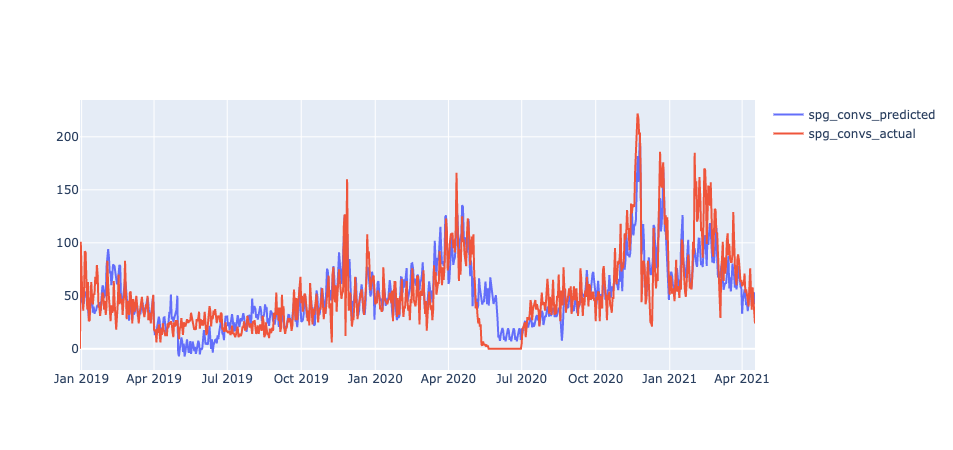

In [239]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ols_vis.index, y=ols_vis['y_pred'],
                    mode='lines',
                    name='spg_convs_predicted'))
fig.add_trace(go.Scatter(x=ols_vis.index, y=ols_vis['y_actual'],
                    mode='lines',
                    name='spg_convs_actual'))

fig.show()

__Try holding out the last few months__

In [240]:
is_s = '2019-01-01'
is_e = '2020-12-31'

oos_s = '2021-01-01'
oos_e = '2021-04-01'

X_train = X.loc[is_s:is_e]
X_test = X.loc[oos_s:oos_e]

y_train = y.loc[is_s:is_e]
y_test = y.loc[oos_s:oos_e]

In [241]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)


ols = sm.OLS(y_train, X_train).fit() 

ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     core_ck_conversions_all   R-squared:                       0.763
Model:                                 OLS   Adj. R-squared:                  0.753
Method:                      Least Squares   F-statistic:                     74.53
Date:                     Mon, 19 Apr 2021   Prob (F-statistic):          1.16e-194
Time:                             19:34:44   Log-Likelihood:                -3072.5
No. Observations:                      725   AIC:                             6207.
Df Residuals:                          694   BIC:                             6349.
Df Model:                               30                                         
Covariance Type:                 nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          16.1610      1.873      8.630      0.000      12.484      19.838
impressions_Audio            1.073e-05   6.63e-06      1.618      0.106   -2.29e-06    2.37e-05
impressions_Connected Video   3.53e-06   2.37e-06      1.490      0.137   -1.12e-06    8.18e-06
impressions_Display          1.607e-06   1.95e-07      8.253      0.000    1.22e-06    1.99e-06
impressions_Native          -4.689e-08   2.58e-07     -0.182      0.856   -5.53e-07    4.59e-07
impressions_Other           -9.011e-06   2.94e-06     -3.070      0.002   -1.48e-05   -3.25e-06
impressions_Paid Search     -1.524e-05   6.99e-06     -2.181      0.029    -2.9e-05   -1.52e-06
impressions_Social          -3.856e-07   1.13e-07     -3.424      0.001   -6.07e-07   -1.65e-07
impressions_Sponsored Email -3.228e-09   6.83e-10     -4.729      0.000   -4.57e-09   -1.89e-09
impressions_Video           -3.541e-06    3.5e-06     -1.011      0.312   -1.04e-05    3.34e-06
impressions_Youtube          9.188e-06   3.12e-06      2.941      0.003    3.05e-06    1.53e-05
ck_impressions              -1.559e-07   7.56e-07     -0.206      0.837   -1.64e-06    1.33e-06
month_April                   -10.9689      2.670     -4.109      0.000     -16.211      -5.727
month_August                    6.0159      2.385      2.523      0.012       1.334      10.698
month_December                  2.6106      2.967      0.880      0.379      -3.215       8.437
month_February                  9.9688      2.808      3.551      0.000       4.456      15.481
month_January                   5.2519      3.559      1.476      0.140      -1.736      12.239
month_July                     -2.5765      2.552     -1.009      0.313      -7.588       2.435
month_June                    -12.4907      2.539     -4.920      0.000     -17.475      -7.506
month_March                     2.1902      2.618      0.837      0.403      -2.949       7.330
month_May                     -24.0907      2.508     -9.607      0.000     -29.014     -19.167
month_November                 25.6485      3.089      8.303      0.000      19.583      31.714
month_October                   6.5056      2.681      2.427      0.015       1.242      11.769
month_September                 8.0963      2.480      3.265      0.001       3.227      12.966
weekday_Friday                  2.3658      1.587      1.491      0.136      -0.750       5.482
weekday_Monday                  4.4391      1.612      2.754      0.006       1.275       7.604
weekday_Saturday                7.7906      1.620      4.810      0.000       4.610      10.971
weekday_Sunday                  8.5662      1.616      5.300      0.000       5.393      11.740
weekday_Thursday               -4.1248      1.583   

In [242]:
#####################################
# TRAIN
######################################

train_ols_y_pred = ols.predict(X_train)

train_ols_vis = X_train.copy()
train_ols_vis['y_pred'] = train_ols_y_pred
train_ols_vis['y_actual'] = y_train

#####################################
# TEST
######################################
test_ols_y_pred = ols.predict(X_test)

test_ols_vis = X_test.copy()
test_ols_vis['y_pred'] = test_ols_y_pred
test_ols_vis['y_actual'] = y_test

######################################
# COMBINE
######################################

ols_vis = pd.concat([train_ols_vis,test_ols_vis])

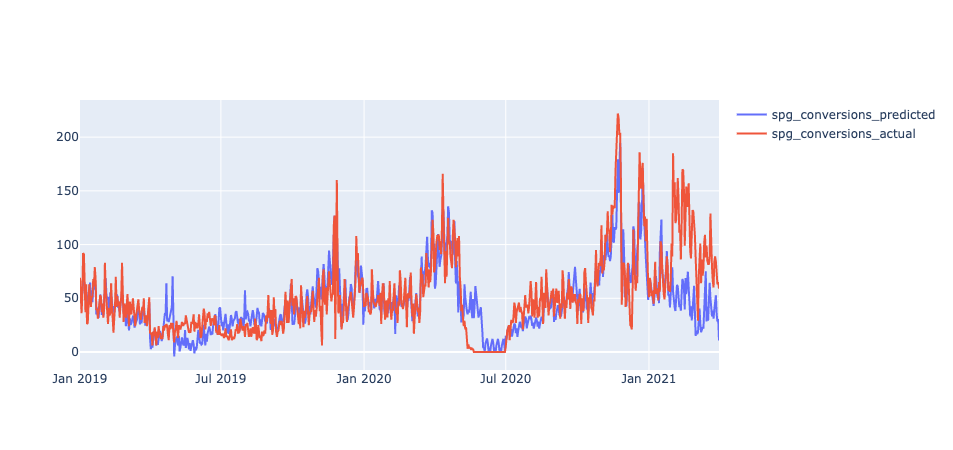

In [243]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ols_vis.index, y=ols_vis['y_pred'],
                    mode='lines',
                    name='spg_conversions_predicted'))
fig.add_trace(go.Scatter(x=ols_vis.index, y=ols_vis['y_actual'],
                    mode='lines',
                    name='spg_conversions_actual'))

fig.show()